# Template for Practical work on the Conversion of sampling frequency and STFT


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**python version : 3.6**

In [1]:
import os, sys, wave, struct

import numpy as np
from IPython.display import Audio
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

## Functions

In [3]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [4]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [5]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [67]:
play = False
if play :
    play_sound(sound) 

In [6]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [7]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

In [ ]:
plot_sound(x, times)

In [12]:
write('new_caravan.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

C:\Users\ayman\AppData\Local\Temp\ipykernel_13148\2618178685.py:20: RuntimeWarning: divide by zero encountered in log
  plt.plot(freq, 20*np.log(np.abs(H)))


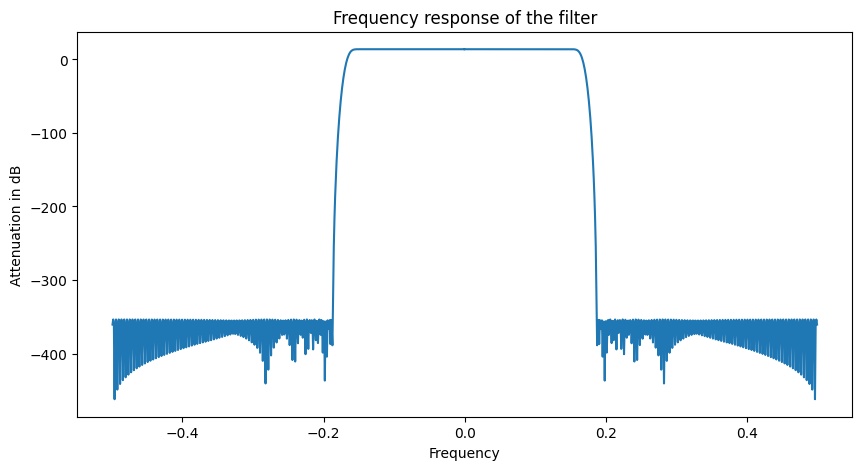

In [8]:
## Conversion of sampling rate

#Question 2

import scipy.signal

even_length = 256
nu_c = 1/6
epsilon = 0.02
L = 2

h = scipy.signal.remez(even_length, [0, nu_c-epsilon, nu_c+epsilon, 0.5], [L, 0])

H = np.fft.fft(h, 1024)

freq = np.fft.fftfreq(1024)
#freq = np.fft.fftshift(freq)

plt.figure(figsize=(10, 5))
plt.plot(freq, 20*np.log(np.abs(H)))
plt.xlabel('Frequency')
plt.ylabel('Attenuation in dB')
plt.title('Frequency response of the filter')
plt.show()


In [ ]:
#Question 3
def downsample(x, L):
    n = len(x)
    x_down = np.zeros(n//L)
    x_down = x[::L]
    return x_down

def upsample(x, L):
    n = len(x)
    x_up = np.zeros(n*L)
    x_up[::L] = x
    return x_up

def shift(x, n):
    x_shift = np.roll(x, n)
    return x_shift

def resample():

    x_up = upsample(x, 2)

    v = scipy.signal.lfilter(h, 1, x_up)

    y = downsample(v, 3)
    return y

y = resample()

print('x display:')
display(Audio(data=x, rate=Fs))
print('y display')
display(Audio(data=y, rate=Fs*2/3))


In [ ]:
#Question 5
import time


def efficient_resample():

    r0 = h[::2]
    r1 = h[1::2]

    e00 = r0[::3]
    e01 = r0[1::3]
    e02 = r0[2::3]
    e10 = r1[::3]
    e11 = r1[1::3]
    e12 = r1[2::3]

    u = shift(x,1)
    v = x
    
    u0 = downsample(u, 3)
    u1 = downsample(shift(u,-1), 3)
    u2 = downsample(shift(u,-2), 3)

    v0 = downsample(v, 3)
    v1 = downsample(shift(v,-1), 3)
    v2 = downsample(shift(v,-2), 3)

    w = upsample(scipy.signal.lfilter(e00,[1],v0) + scipy.signal.lfilter(e01,[1],v1) + scipy.signal.lfilter(e02,[1],v2),2) + shift(upsample(scipy.signal.lfilter(e10,[1],u0) + scipy.signal.lfilter(e11,[1],u1) + scipy.signal.lfilter(e12,[1],u2),2),-1)

    return w

w = efficient_resample()


print('x display:')

display(Audio(data=x, rate=Fs))

print('w display')

display(Audio(data=w, rate=Fs*2/3))

print('y display')

display(Audio(data=y, rate=Fs*2/3))

print(x.shape, y.shape, w.shape)


In [27]:
import time

Resampling_0 = time.time()
y_0 = resample()
Resampling_1 = time.time()

Efficient_0 = time.time()
y_1 = efficient_resample()
Efficient_1 = time.time()

print((Resampling_1 - Resampling_0) - (Efficient_1 - Efficient_0))

0.03131580352783203


## Signal analysis with the STFT

In [71]:
N = x.shape[0] # % longueur du signal
Nw = 512
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = Nw/4 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 512 # ordre de la tfd
L = M/2+1
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

In [16]:
for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
    if affich:
        Xtilde[:,u] = X
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

In [ ]:
if affich:
    plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0,L),:])), aspect='auto',interpolation='none',
               origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])
    

C:\Users\ayman\AppData\Local\Temp\ipykernel_22400\3659478215.py:10: RuntimeWarning: divide by zero encountered in log
  plt.plot(freq, 20*np.log(np.abs(W)))


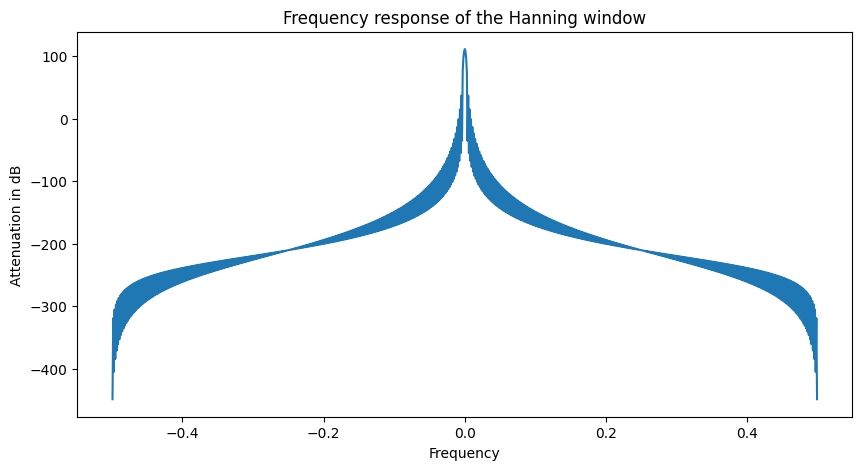

In [25]:
## STFT audio equalization

#Question 1

def plot_hanning(Nw,M):
    w = np.hanning(Nw)
    W = np.fft.fft(w,M)
    freq = np.fft.fftfreq(M)  
    plt.figure(figsize=(10, 5))
    plt.plot(freq, 20*np.log(np.abs(W)))
    plt.xlabel('Frequency')
    plt.ylabel('Attenuation in dB')
    plt.title('Frequency response of the Hanning window')
    plt.show()

plot_hanning(Nw, Nw*2)

805717


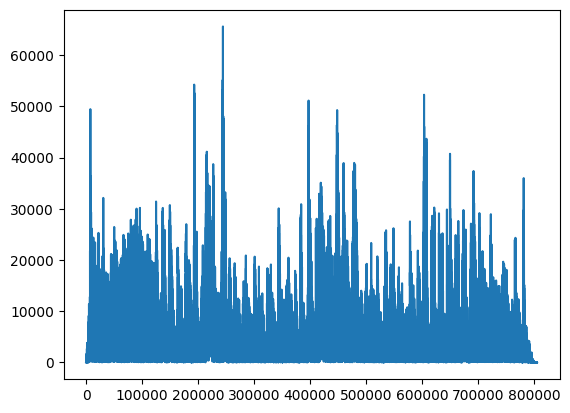

In [29]:
#Question 4
wavefile = load_sound(sound)
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)
N = x.shape[0] # % longueur du signal

k = 3
R =1
M = 32
Nw = 16
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
L = M/2+1
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = int((N - Nw) / R) # calcul du nombre de tfd à calculer
#Nt = Nt.astype(int)
print(Nt)

X_tilde = np.zeros((M,Nt),dtype=complex)
for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,M) 
    X_tilde[:,u] = X

x_3 = X_tilde[k,:]

plt.plot(np.abs(x_3))
plt.show()



In [ ]:
print(np.imag(x_3)==0)

In [ ]:
display(Audio(data=np.real(x_3), rate=Fs))

## Overlap-add reconstruction

3143 1024 256.0


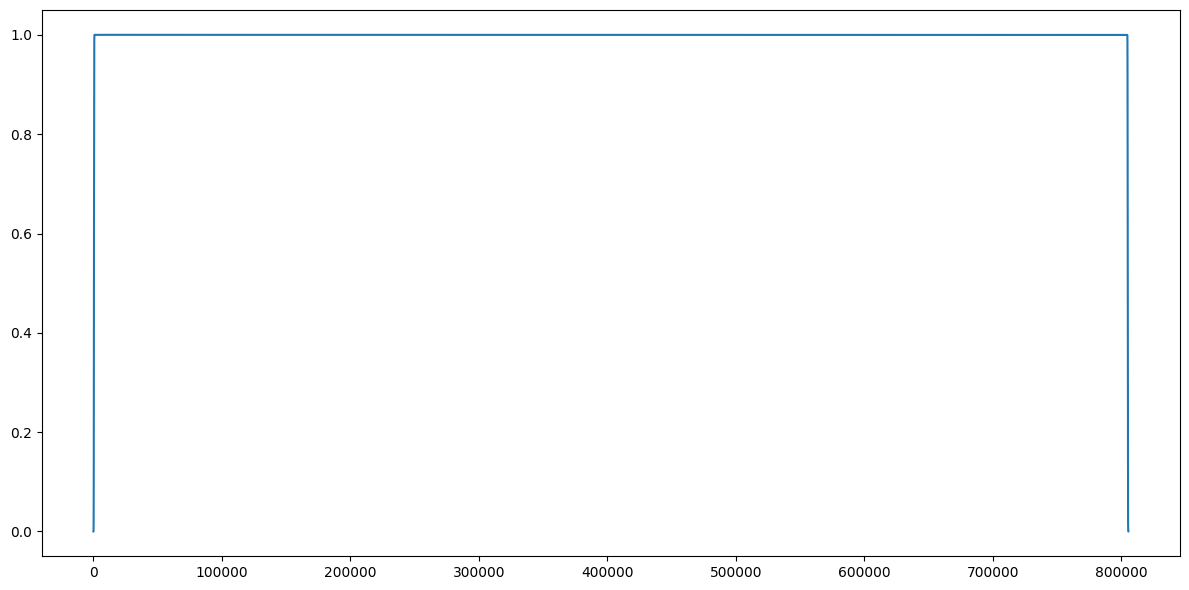

' \nabs = np.arange(-100,101)\nord = [test_Fenetre(n,w) for n in range (-100, 101)]\nplt.plot(abs,ord)  '

In [72]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output

def normalize(h):
    sum = 0
    for k in range(len(h)):
        sum += h[k]**2
    return np.multiply(h,2/np.sqrt(sum)) # normalisation en utilisant la norme 2 mais divisant par 2 pour que cela puisse fonctionné avec un recouvrement de 75%

def new_normalize(h,R):  #Ce choix de formule pour la normalisation est explicité dans le compte rendue
    s = 0
    for k in range(len(h)//R):
        s = s + h[k*R]**2
    return np.multiply(h,1/np.sqrt(s))

print(Nt,Nw,R)
h = np.hanning(Nw)

h = new_normalize(h,int(R))

w = np.multiply(h,h)

y = ola(w,int(R),Nt)

plt.figure(figsize=(12, 6))
plt.plot(y)
plt.tight_layout()
plt.show()  
 
""" 
abs = np.arange(-100,101)
ord = [test_Fenetre(n,w) for n in range (-100, 101)]
plt.plot(abs,ord)  """

In [ ]:
s = ola(w,int(R),Nt)
s = s[:,0]
x = x[:len(s)]

y = np.multiply(s,x)

display(Audio(data=y, rate=Fs))
display(Audio(data=x, rate=Fs))